## Getting data from the full dataset via: CAVEclient('minnie65_public')

In [1]:
from meshparty import trimesh_io, trimesh_vtk, skeleton, utils, skeletonize
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from caveclient import CAVEclient
import meshparty.skeleton_io

In [18]:
some_id = 864691136274724621 #864691135207734905 # a root id from aibs_metamodel_mtypes_v661_v2	table

## Get Mesh / Skeleton

In [3]:
def plot_sk_or_mesh(sk_or_mesh, in_3d=True, sample=50, soma=None, syn_list=None, syn_size=1,
                    ex_syn=None, inh_syn=None):
    if in_3d:
        fig = plt.figure(figsize=(8, 8))
        ax = plt.axes(projection='3d')

        if soma is not None:
            ax.scatter3D(soma[0], soma[1], soma[2], c='red', s=200, alpha=1, label='soma')
        if syn_list is not None:
            ax.scatter3D(syn_list[:,0], syn_list[:,1], syn_list[:,2], c='purple', s=syn_size, alpha=.8, label='syn')
        if ex_syn is not None:
            ax.scatter3D(ex_syn[:,0], ex_syn[:,1], ex_syn[:,2], c='green', s=syn_size, alpha=.8, label='ex syn')
        if inh_syn is not None:
            ax.scatter3D(inh_syn[:,0], inh_syn[:,1], inh_syn[:,2], c='purple', s=syn_size, alpha=.8, label='in syn')
        
        ax.scatter3D(sk_or_mesh.vertices[::sample,0],
                     sk_or_mesh.vertices[::sample,1],
                     sk_or_mesh.vertices[::sample,2], s=0.8, alpha=.5, label='mesh/sk')
    else: 
        f,ax = plt.subplots(figsize=(8,8))
        ax.scatter(sk_or_mesh.vertices[::sample,0], sk_or_mesh.vertices[::sample,1], s=1, alpha=.2, label='mesh/sk')
    
        if soma is not None:
            ax.scatter(soma[0], soma[1], c='red', s=100, alpha=0.9, label='soma')
        if syn_list is not None:
            ax.scatter(syn_list[:,0], syn_list[:,1], c='purple', s=syn_size, alpha=.8, label='syn')
        if ex_syn is not None:
            ax.scatter(ex_syn[:,0], ex_syn[:,1], c='green', s=syn_size, alpha=.9, label='ex syn')
        if inh_syn is not None:
            ax.scatter(inh_syn[:,0], inh_syn[:,1], c='purple', s=syn_size, alpha=.9, label='inh syn')
            
        ax.set_aspect('equal')
        ax.set_ylim(np.max(sk_or_mesh.vertices[:,1]), np.min(sk_or_mesh.vertices[:,1]))

    lgnd = plt.legend(scatterpoints=1)
    for handle in lgnd.legend_handles:
        handle.set_sizes([50.0])

In [19]:
# the full dataset
client = CAVEclient('minnie65_public')

# Download mesh
mm = trimesh_io.MeshMeta(
  cv_path=client.info.segmentation_source(),
  disk_cache_path="data",
)

mesh = mm.mesh(seg_id=some_id, remove_duplicate_vertices=True)
mesh.vertices.shape

(947340, 3)

In [20]:
# Download skeleton
sk_dict = client.skeleton.get_skeleton(some_id, output_format='json')
sk_dict.keys()

sk = meshparty.skeleton.Skeleton(
    vertices=np.array(sk_dict['vertices']),
    edges=np.array(sk_dict['edges']),
    mesh_to_skel_map=sk_dict['mesh_to_skel_map'],
    vertex_properties=sk_dict['vertex_properties'],
    root=sk_dict['root'],
    meta=sk_dict['meta'],
)
print(sk.vertices.shape)

(1054, 3)


In [21]:
# Calcualte skeleton based on the mesh
sk_calculated = skeletonize.skeletonize_mesh(mesh, invalidation_d=12000)
print(type(sk_calculated))
print(sk_calculated.vertices.shape)

C:\Users\dean\Documents\dev\Connectomics\OFS-EM-Connectomics\.venv\lib\site-packages\meshparty\skeletonize.py:622: RuntimeWarning:

invalid value encountered in multiply



<class 'meshparty.skeleton.Skeleton'>
(23970, 3)


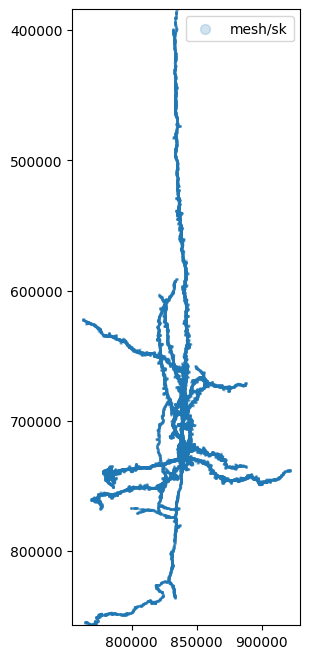

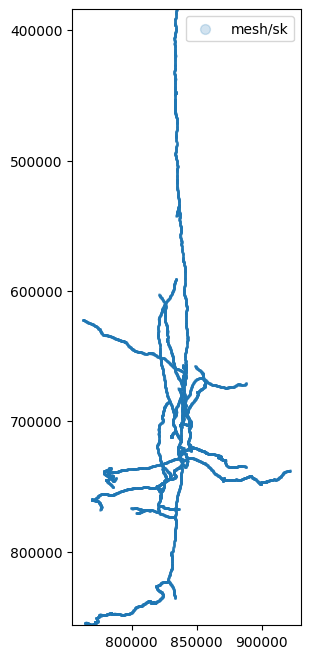

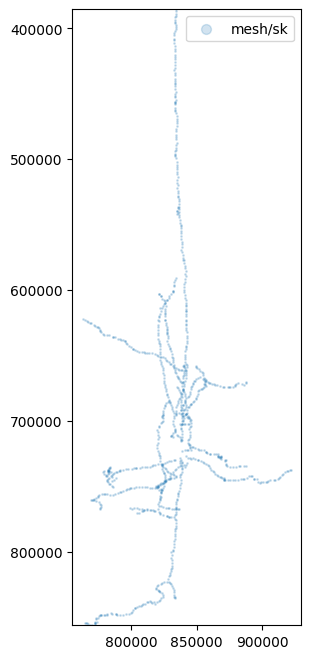

In [22]:
plot_sk_or_mesh(mesh, in_3d=False, sample=20)
plot_sk_or_mesh(sk_calculated, in_3d=False, sample=1)
plot_sk_or_mesh(sk, in_3d=False, sample=1)

## Get Synapses + Soma

In [38]:
# soma_table_file = 'data/aibs_metamodel_mtypes_v661_v2.csv'
soma_table_file = 'data/aibs_metamodel_celltypes_v661.csv'

soma_df = pd.read_csv(soma_table_file)

print(len(soma_df))
# some root ids are 0...
print(len(set(soma_df.root_id.unique())))

ids = set(soma_df.root_id.unique())

94014
91425


In [24]:
syn_df = client.materialize.synapse_query(pre_ids=some_id)
print(f"Total number of output synapses for {some_id}: {len(syn_df)}")

Total number of output synapses for 864691136274724621: 64


In [39]:
cell_post_subgraph = client.materialize.synapse_query(post_ids=some_id)
print(f"Total number of input synapses for {some_id}: {len(cell_post_subgraph)}")
cell_post_subgraph.head()

Total number of input synapses for 864691136274724621: 1186


,id,created,superceded_id,valid,size,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,pre_pt_position,post_pt_position,ctr_pt_position
0,215109390,2020-11-04 06:48:58.343057+00:00,NaN,t,3212,93457390460418791,864691135098652205,93457390460431057,864691136274724621,"[208652, 118172, 27571]","[208698, 118094, 27583]","[208672, 118148, 27578]"
1,213739481,2020-11-04 06:48:59.510128+00:00,NaN,t,1844,93816930427121630,864691135279236769,93816930427130375,864691136274724621,"[211274, 175506, 24950]","[211366, 175544, 24959]","[211298, 175482, 24956]"
2,212711563,2020-11-04 06:49:10.903020+00:00,NaN,t,5132,93673032178133521,864691134679674203,93673032178137783,864691136274724621,"[210434, 151980, 27277]","[210412, 151892, 27275]","[210428, 151932, 27278]"
3,241501003,2020-11-04 06:53:26.207097+00:00,NaN,t,172,95648029604047125,864691135777916861,95648098323516032,864691136274724621,"[224778, 186988, 24772]","[224716, 187122, 24779]","[224746, 187050, 24776]"
4,225223024,2020-11-04 07:15:03.145297+00:00,NaN,t,3416,94239967593175673,864691135521550578,94239967593179248,864691136274724621,"[214110, 181556, 25579]","[214198, 181616, 25579]","[214170, 181576, 25579]"


Synapses: 1186
Soma loc [nM]: [839040 723328 1083040]


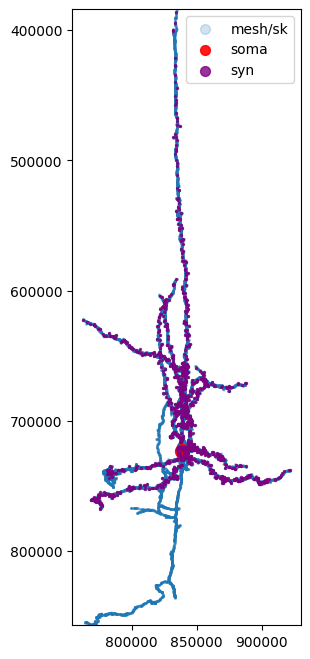

In [26]:
print(f'Synapses: {len(cell_post_subgraph)}')
# convert voxel to nM
syn_xyz = np.array(cell_post_subgraph.ctr_pt_position.tolist()) * np.array([4,4,40])

# Handle Soma
soma_cell_df = soma_df.query(f'root_id =={some_id}')
if len(soma_cell_df) > 1:
    print('err?')

soma_xyz = soma_cell_df.iloc[0][['pt_position_x', 'pt_position_y', 'pt_position_z']].values
print(f'Soma loc [nM]: {soma_xyz}')

plot_sk_or_mesh(mesh, in_3d=False, sample=20, soma=soma_xyz, syn_list=syn_xyz, syn_size=2)

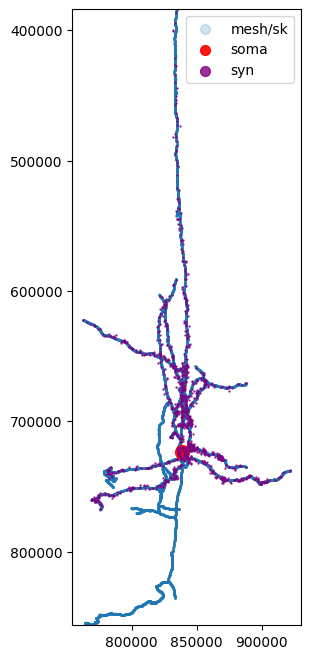

In [27]:
plot_sk_or_mesh(sk_calculated, in_3d=False, sample=1, soma=soma_xyz, syn_list=syn_xyz, syn_size=0.5)

### Get the type of those presynaptic neurons

Ex  Synapses: 58
Inh Synapses: 100


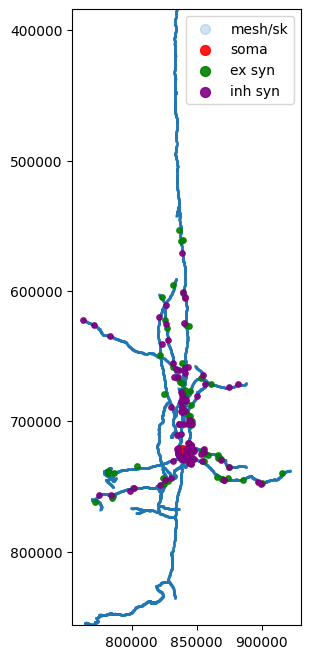

In [28]:
inh_root_ids = set(soma_df.query('classification_system=="inhibitory_neuron"')['root_id'].values)
ex_root_ids = set(soma_df.query('classification_system=="excitatory_neuron"')['root_id'].values)

inh_syn_df = cell_post_subgraph.query('pre_pt_root_id in @inh_root_ids')
ex_syn_df = cell_post_subgraph.query('pre_pt_root_id in @ex_root_ids')

print(f'Ex  Synapses: {len(ex_syn_df)}')
print(f'Inh Synapses: {len(inh_syn_df)}')

inh_syn_xyz = None
if len(inh_syn_df):
    inh_syn_xyz = np.array(inh_syn_df.ctr_pt_position.tolist()) * np.array([4,4,40])

ex_syn_xyz = None
if len(ex_syn_df):
    ex_syn_xyz = np.array(ex_syn_df.ctr_pt_position.tolist()) * np.array([4,4,40])

plot_sk_or_mesh(sk_calculated, in_3d=False, sample=1, soma=soma_xyz, ex_syn=ex_syn_xyz, inh_syn=inh_syn_xyz, syn_size=15)

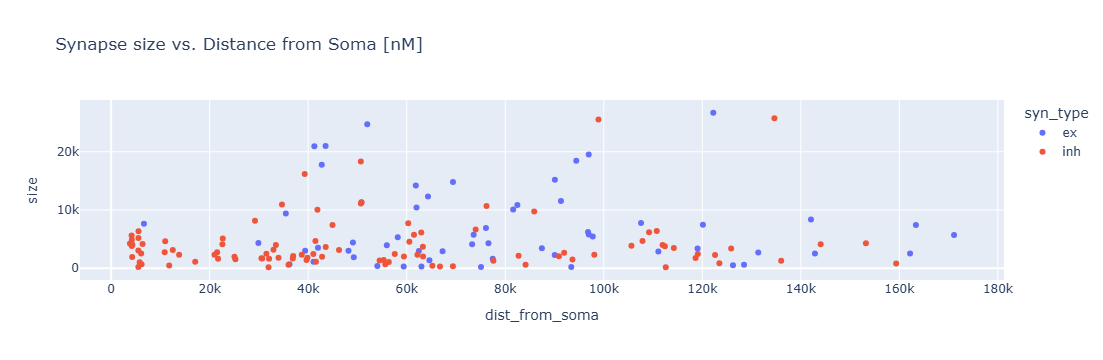

In [29]:
# TODO: fix euclid distance to dikstra / over the tree
import plotly.express as px
pd.options.mode.copy_on_write = True

def synapse_dist_from_soma(syn):
    syn_xyz = syn.ctr_pt_position.tolist() * np.array([4,4,40])
    return np.linalg.norm(soma_xyz - syn_xyz)

inh_syn_df['dist_from_soma'] = inh_syn_df.apply(synapse_dist_from_soma, axis=1).copy()
inh_syn_df['syn_type'] = 'inh'

ex_syn_df['dist_from_soma'] = ex_syn_df.apply(synapse_dist_from_soma, axis=1).copy()
ex_syn_df['syn_type'] = 'ex'

syn_df = pd.concat([ex_syn_df, inh_syn_df])
fig = px.scatter(syn_df, x="dist_from_soma", y="size", color="syn_type",
                 title="Synapse size vs. Distance from Soma [nM]")
fig.show()